# Linear Regression on Housing Data
In the first lab assignment, you played with Boston Housing Dataset. In this lab assignment, you are going to implement a linear regression model trained on Boston Housing Data by using Knet for the first time. We will take advantage of iterators, callable objects and automatic differentation mechanism.

In [1]:
# Do not touch this cell
# Necessary imports
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
using Test
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

## Data Reading
You do not need to worry about data reading and preprocessing: We are going to take advantage of housing data reader which is also a part of Knet. We include some source file and then use ```housing``` function. ```housing``` function takes one input argument: the percentage of the test set to split dataset into two parts. Just take a look at the cell below. In this lab session, we are going to use 20% of the data as test split.

In [2]:
# Do not touch this cell
# Load data
include(joinpath(Knet.dir(), "data", "housing.jl"))
Knet.seed!(1)
xtrn, ytrn, xtst, ytst = housing(0.20; url="https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data")

([-0.410442951130207 -0.11370556630644414 … -0.32875762699414984 -0.41501073511771897; -0.4872401872268264 -0.4872401872268264 … 0.37030254229238807 2.9429307308500317; … ; 0.37599013494349426 -0.06817504645565328 … 0.3000822506747866 0.4406158949991036; 0.18581785870133055 -0.0018293136231862705 … 0.299246373315404 -0.3379138013685896], [26.4 16.1 … 30.7 19.4], [-0.40098999831716037 -0.416566269598577 … -0.40370578945862845 -0.40547756415879854; 0.4560568152443095 -0.4872401872268264 … -0.4872401872268264 1.4422309541914062; … ; 0.19755731607809054 0.41772304101330315 … 0.4406158949991036 0.2866094227309898; -0.4387391476922107 -0.29310253633586913 … 0.44628333670401804 -1.1333137556993775], [24.5 18.5 … 20.3 29.8])

In [3]:
# Print size of data matrices for testing
size(xtrn), size(ytrn), size(xtst), size(ytst)

((13, 405), (1, 405), (13, 101), (1, 101))

## Minibatching via Iterators
In this part, you are going implement a minibatching procedure (or let's call it pipeline). Remember, you need to implement your own ```minibatch``` function, it's forbidden to use Knet's ```minibatch``` procedure. Also, your minibatching scheme must use iterators. Just take a look at [this blog post](https://julialang.org/blog/2018/07/iterators-in-julia-0.7). To implement your minibatching pipeline, we provide you ```HousingData``` struct definition. Different from the original implementation, you are not going to discard the last remaining smaller minibatch, you will use all the instances. Also, remember that, ```HousingData``` structure is not mutable which means you are not able to change the values inside struct.

In [4]:
# Do not touch this cell
# HousingDataMinibatch struct definition
# As default, this struct definition also creates the following constructor,
#   HousingDataMinibatch(x, y, batchsize, shuffle, ninstances)
# where x is input data, y is output data, batchsize is number of samples in
# a minibatch, shuffle is a boolean property which indicates shuffling
# instances or not, ninstances is number of instances in the whole data split.
# This constructor returns a HousingDataMinibatch object.
struct HousingDataMinibatch
    x
    y
    batchsize
    shuffle # shuffle data in each epoch or not
    ninstances # number of instances
end

In [5]:
# HousingDataMinibatch(x, y; batchsize=100, dtype=Array{Float64}, shuffle=false)
#
# Creates a HousingDataMinibatch object. It takes two positional arguments, x
# and y, input and output data for the data split. It also take three optional
# keyword arguments: batchsize (number of instances in a minibatch), dtype
# (data type for minibatch arrays) and shuffle (if true, shuffle instances).
function HousingDataMinibatch(x, y; batchsize=100, dtype=Array{Float64}, shuffle=false)
    ninstances = size(x)[end]
    data = HousingDataMinibatch(convert(dtype, x), convert(dtype, y), batchsize, shuffle, ninstances)
    return data
end

HousingDataMinibatch

## Tests for ```HousingDataMinibatch(x, y; ...)```

In [6]:
x1 = randn(5, 100); y1 = rand(1, 100)
obj1 = HousingDataMinibatch(
    x1, y1; batchsize=20, dtype=Array{Float32}, shuffle=true)
@test obj1.shuffle == true
@test typeof(obj1.x) <: Array{Float32}
@test typeof(obj1.y) <: Array{Float32}
@test obj1.batchsize == 20
@test obj1.ninstances == 100
@test abs2(sum(obj1.x - x1)) < 1e-6
@test abs2(sum(obj1.y - y1)) < 1e-6
@info "constructor tests passed"

┌ Info: constructor tests passed
└ @ Main In[6]:11


In [7]:
# length(d)
# Returns how many batches the dataset (d) has.
# Hint: You can use divrem function. Type ?divrem to see how to use.
function length(d::HousingDataMinibatch)
    d, r = divrem(d.ninstances, d.batchsize)
    return r == 0 ? d : d+1
end

length (generic function with 157 methods)

## Tests for ```length(d::HousingDataMinibatch)```

In [8]:
x1 = randn(5, 100); y1 = rand(1, 100)
test_helper1(batchsize) = HousingDataMinibatch(x1,y1; batchsize=batchsize)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
@test map(length, objects) == [5, 4, 2, 1, 1]
@info "length tests passed"

┌ Info: length tests passed
└ @ Main In[8]:5


In [9]:
# iterate(d, state)
# Takes a HousingDataMinibatch object as d and list of integers as state.
# Returns one minibatch.
# This is how you implement your own iterator!
function iterate(d::HousingDataMinibatch, state=ifelse(
    d.shuffle, randperm(d.ninstances), collect(1:d.ninstances)))
    n = length(state)
    n == 0 && return nothing
    batchsize = min(d.batchsize, n)
    indices, new_state = state[1:batchsize], state[batchsize+1:end]
    x, y = d.x[:, indices], d.y[:, indices]
    return ((x,y), new_state)
end

iterate (generic function with 294 methods)

In [10]:
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)

HousingDataMinibatch([-0.40098999831716037 -0.416566269598577 … -0.40370578945862845 -0.40547756415879854; 0.4560568152443095 -0.4872401872268264 … -0.4872401872268264 1.4422309541914062; … ; 0.19755731607809054 0.41772304101330315 … 0.4406158949991036 0.2866094227309898; -0.4387391476922107 -0.29310253633586913 … 0.44628333670401804 -1.1333137556993775], [24.5 18.5 … 20.3 29.8], 100, false, 101)

## Tests for ```iterate``` function

In [11]:
x1 = randn(5, 100); y1 = rand(1, 100)
test_helper2(batchsize) = HousingDataMinibatch(x1,y1; batchsize=batchsize)
test_helper3(batches) = mapreduce(bi->size(bi[2],2), +, batches)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
data_arrays = map(collect, objects)
num_instances = map(test_helper3, data_arrays)
@test map(length, data_arrays) == map(length, objects)
@test prod(num_instances .== 100) == 1
@info "iterate tests passed"

┌ Info: iterate tests passed
└ @ Main In[11]:9


## Model Implementation via Callable Objects
Next, we are going to implement our model via callable objects. In Julia, we can call objects. Just give a glimpse at the following code snippet:

In [12]:
struct Hello
    planet
    Hello(planet="World") = new(planet)
end

(obj::Hello)() = println("Hello, $(obj.planet)!")

hello_world = Hello()
hello_world()

hello_jupiter = Hello("Jupiter")
hello_jupiter()

Hello, World!
Hello, Jupiter!


For this assingment, you just need to define a linear layer and that's all! Write your solutions to the below cell. Hint: You need to use ```Param``` method of AutoGrad. Just type ```@doc Param``` to see the documentation.

In [13]:
struct Linear
    # Your code here
    w 
    b
    #
end

function (l::Linear)(x)
    # Your code here
    l.w * x .+ l.b
    #
end

function Linear(xsize::Int, ysize::Int, atype=Array{Float64}, scale=0.1)
    # Your code here
    return Linear(Param(randn(ysize,xsize) .* 0.1),Param(zeros(ysize,1)))
    #
end

model = Linear(13, 1)

Linear(P(Array{Float64,2}(1,13)), P(Array{Float64,2}(1,1)))

## Tests for ```Linear```

In [14]:
test_model = Linear(5,3)
test_data = rand(5,10)
@test fieldnames(Linear) == (:w, :b)
@test typeof(test_model.w) <: Param
@test typeof(test_model.b) <: Param
@test size(test_model.w) == (3,5)
@test size(test_model.b) == (3,1)
@test sum(test_model.b.value) ≈ 0.0
@test size(test_model(test_data)) == (3,10)
@info "Linear tests passed"

┌ Info: Linear tests passed
└ @ Main In[14]:10


## Define Loss Function
In this part, we'll define our loss function. We are going to use minimum squared error loss function,

![MSE](http://web.itu.edu.tr/keseni/mse.png)

We're going to define three diffent functions for this purpose,

1. A function takes predictions and gold values as input.
2. A callable object procedure that takes input/output pair as input
3. A callable object procedure that takes our dataset object as input

See function prototypes below and the documentation of ```train!``` function.

1 - takes predictions and gold values as input.

In [15]:
function mse(ypred, ygold)
    # Your code here
    sum((ypred .- ygold) .* (ypred .- ygold)) ./ (2*size(ygold)[2])
    #
end

mse (generic function with 1 method)

2 - callable object procedure that takes input/output pair as input

In [16]:
function (m::Linear)(x, y)
    # Your code here
    mse(m(x),y)
    #
end

3 - callable object procedure that takes our dataset object as input

In [17]:
function (m::Linear)(data::HousingDataMinibatch)
    # Your code here
     m(data.x,data.y)
    #
end

## Tests for ```mse```

In [18]:
x1 = randn(5, 100); y1 = rand(1, 100); batchsize = 20
test_data = HousingDataMinibatch(x1,y1; batchsize=batchsize, shuffle=false)
test_model = Linear(5, 1)
batch = take(test_data,1)
w1, b1 = test_model.w.value, test_model.b.value
y2 = w1 * x1 .+ b1
@test mse(y2,y1) ≈ 0.5mean(abs2.(y1 - y2))
@test test_model(test_data) ≈ mse(y2,y1)
@info "mse tests passed"

┌ Info: mse tests passed
└ @ Main In[18]:9


## Training with Modular Interface and Iterators
Now, let's implement a ```mytrain!``` procedure to train our network! It takes model, train data, test data, report period (in iterations) and number of maximum iterations. It trains our model until a certain maximum iterations number, records loss values of train and test data splits after each report period. It should output three lists: iterations numbers, loss values of train set, loss values of test set.

Hint: You will need ```sgd!```, ```cycle``` and ```take``` procedures.

In [19]:
function mytrain!(m::Linear, dtrn, dtst, valid=10, max_iters=500)
    # Your code here
    trnloss = [m(dtrn)]
    tstloss = [m(dtst)]
    
    for i in 1:valid:max_iters
        sgd!(m,take(cycle(dtrn),max_iters))
        push!(trnloss,m(dtrn))
        push!(tstloss,m(dtst))
    end
    #
    return 0:valid:max_iters, trnloss, tstloss
end

mytrain! (generic function with 3 methods)

Finally, let's train our network and plot the results,

In [20]:
# ENV["GRDIR"]=""
# Pkg.build("GR")

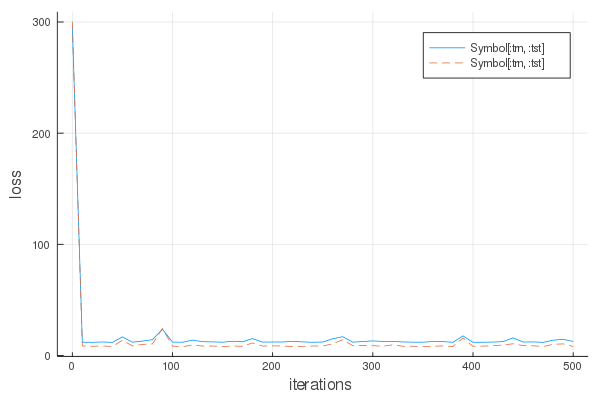

In [21]:
Knet.seed!(42)
model = Linear(13, 1)
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)
iters, trnloss, tstloss = mytrain!(model, dtrn, dtst)
plot(iters, [trnloss, tstloss], labels=[:trn, :tst], xlabel="iterations", ylabel="loss")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*